In [1]:
import geopandas as gpd

In [2]:
data = gpd.read_file('../../data/processed/MBfogo_c10_cerrado_polygons_b150_CM/MBfogo_c10_cerrado_polygons_1985.shp')

In [3]:
data.head()

,year,month,geometry
0,1985,1,"POLYGON ((-44.13755 -16.49927, -44.13728 -16.4..."
1,1985,1,"POLYGON ((-44.23754 -16.27047, -44.23646 -16.2..."
2,1985,1,"POLYGON ((-44.23215 -16.83991, -44.23188 -16.8..."
3,1985,1,"POLYGON ((-44.71724 -17.73625, -44.71670 -17.7..."
4,1985,1,"POLYGON ((-44.69325 -18.13321, -44.69298 -18.1..."


array([[<AxesSubplot:title={'center':'month'}>]], dtype=object)

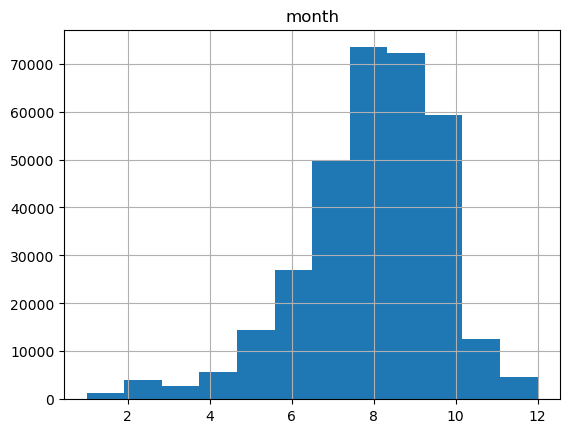

In [4]:
data.hist(column = 'month', bins = 12)

In [5]:
data = data.to_crs('epsg:5880')

In [6]:
data['area'] = data.geometry.area

In [7]:
data['area'] = data['area']*0.0001

In [8]:
data['area'].min()

0.08164273135120018

In [9]:
data['area'].max()

73918.36013124198

array([[<AxesSubplot:title={'center':'area'}>]], dtype=object)

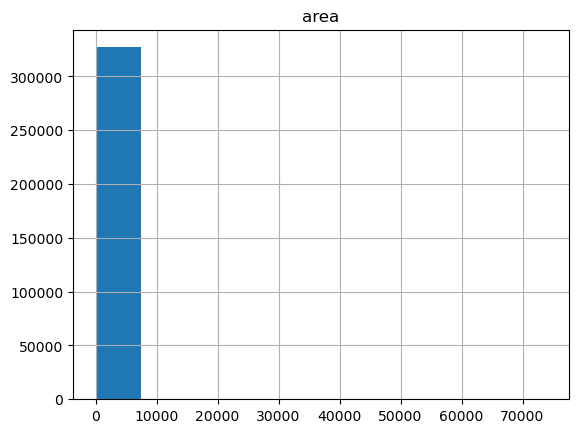

In [10]:
data.hist(column = 'area')

In [11]:
import matplotlib.pyplot as plt

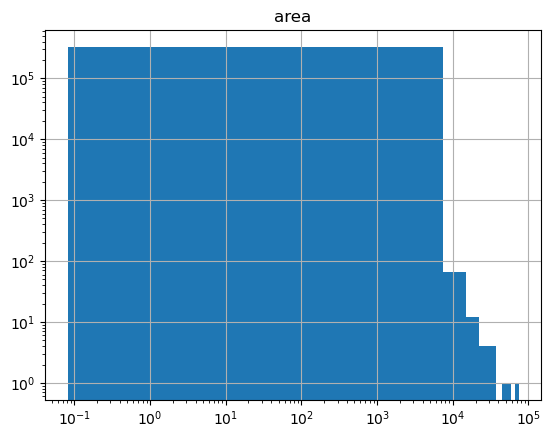

In [12]:
fig, axes = plt.subplots()
data.hist(column = 'area', ax = axes)
axes.set_yscale('log')
axes.set_xscale('log')

In [13]:
import powerlaw
from powerlaw import plot_pdf, Fit, pdf

In [14]:
def basic_powerLawPDF(data, linear_boolean, year):
    # Function that plots the basic histogram 

    fig, axes = plt.subplots(figsize = (10,7))
    
    fig.suptitle('Fire size distribution for the year {}'.format(year))

    # pdf returns the probablity density function (normalised histogram) of the theoretical distibution for the vlaues i ndata within xmin and xmax, if present
    x, y = pdf(data, linear_bins = linear_boolean)
    axes.scatter(x[:-1], y, color = 'r', s = 0.5)

    axes.set_xlabel('Fire size (ha)')
    axes.set_ylabel('Frequency')
    # axes.set_xscale('log')
    # axes.set_yscale('log')
    
    plt.tight_layout()

    plot_pdf(data, ax = axes, color = 'b', linewidth = 2)
    
    plt.subplots_adjust(left = 0.1)
    
    plt.savefig('./fireSizeDistribution_noJoining_{}.png'.format(year))
    
    plt.show()

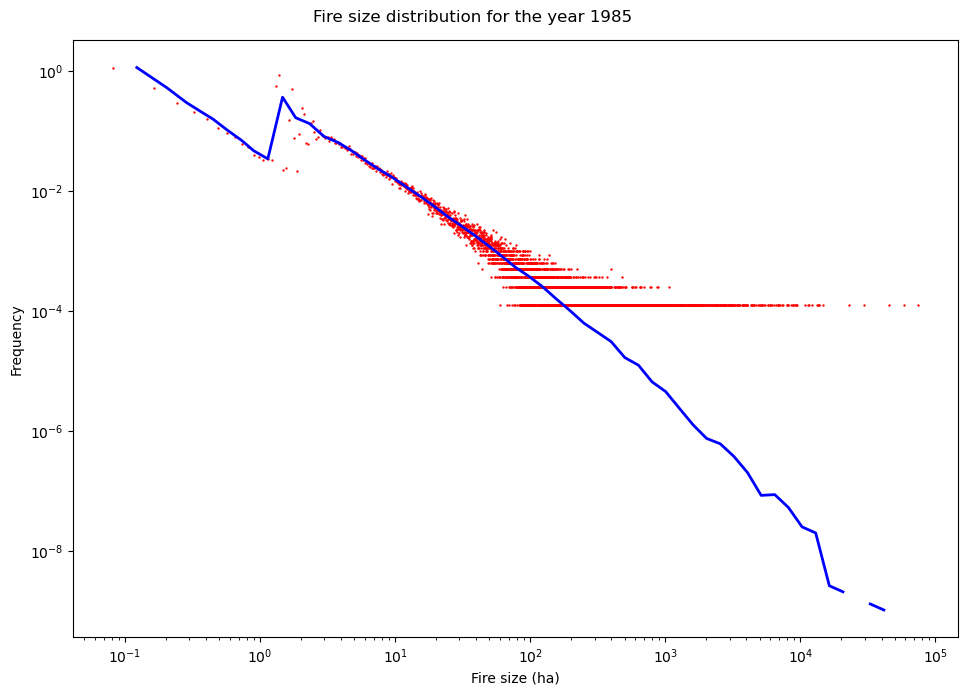

In [16]:
basic_powerLawPDF(data.sample(n=100000, replace = False)['area'], True, '1985')

What is the area per month with this method? I think that a lot of pygons are going to have early months assigned when they shouldn't

In addition, what is the seasonality if I remove the polygons smaller than 2 ha?

In [20]:
areas_month = data[['month','area']].groupby(by='month').sum().reset_index()#.plot().bar(x = 'month', y='area')

<BarContainer object of 12 artists>

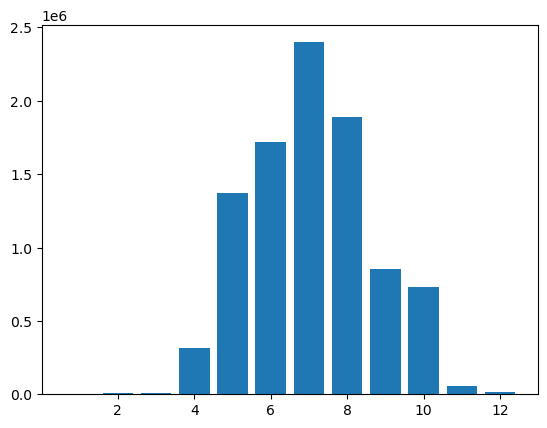

In [27]:
fig, axes = plt.subplots()
axes.bar(x = areas_month['month'], height = areas_month['area'])

Indeed, the method of using the first month in polygon introduces a seasonal bias. This bias is not so clear if you use the number of polygons per month. So what I think happens is that the largeer polygons get assigned earlier months than they should.

In [28]:
data[data['area']==data['area'].max()]

,year,month,geometry,area
28257,1985,5,"MULTIPOLYGON (((5910702.812 9245197.491, 59107...",73918.360131


Indeed looking at this very large polygon, I can see how it should actually have been assigned to either month 9 or 8. In fact, from looking at Landsat raw data (USGS Landsat Look), it would seem like in this case MapBiomas got it right, because it seems to be a fire occurring in August and then another one happening in September surounding the first one. 

I think that a good compromise is to get the month that occupies more area: not a complicated option, it makes sense, it will still have some error but it won't be as large.

## Second method, assign month with largest area in polygon

In [29]:
data2 = gpd.read_file('../../data/processed/MBfogo_c10_cerrado_polygons_b150_CM/MBfogo_c10_cerrado_polygons_1985_freVal.shp')

array([[<AxesSubplot:title={'center':'month'}>]], dtype=object)

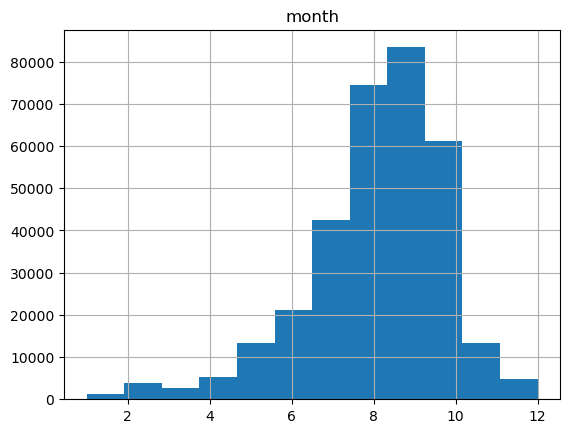

In [30]:
data2.hist(column = 'month', bins = 12)

In [33]:
data2 = data2.to_crs('epsg:5880')

In [34]:
data2['area'] = data2.geometry.area

In [35]:
data2['area'] = data2['area']*0.0001

In [36]:
data2['area'].min()

0.08164273135120018

In [37]:
data2['area'].max()

73918.36013124198

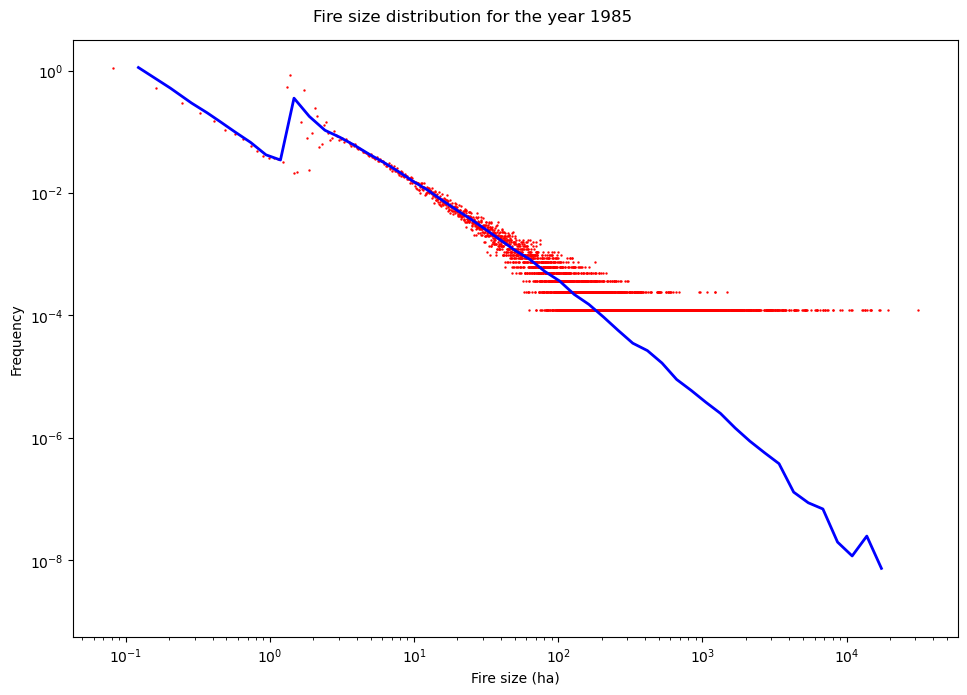

In [38]:
basic_powerLawPDF(data2.sample(n=100000, replace = False)['area'], True, '1985')

In [39]:
areas_month = data2[['month','area']].groupby(by='month').sum().reset_index()#.plot().bar(x = 'month', y='area')

<BarContainer object of 12 artists>

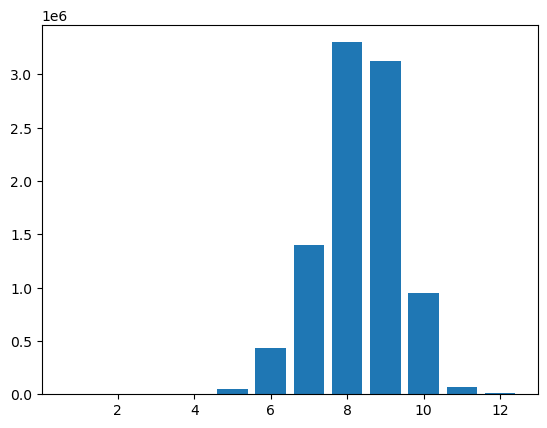

In [40]:
fig, axes = plt.subplots()
axes.bar(x = areas_month['month'], height = areas_month['area'])

Indeed, now both plots look better, especially the one by year. At least, it looks more in line with the issues that we had anyway with MapBiomas FOGO data.

What if we plot the same plots but discarding those polygons smaller than 3 ha?

array([[<AxesSubplot:title={'center':'month'}>]], dtype=object)

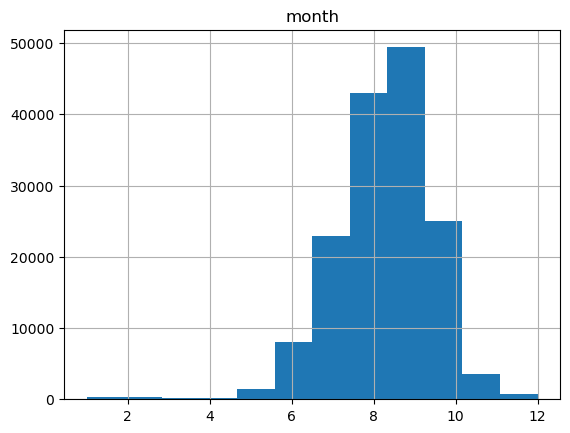

In [41]:
data2[data2['area'] >= 3].hist(column = 'month', bins = 12)

It does substantially diminish the number of polygons per month (from about 80000 in September, to 50000)

In [46]:
areas_month = data2[data2['area'] >= 3][['month','area']].groupby(by='month').sum().reset_index()#.plot().bar(x = 'month', y='area')

<BarContainer object of 12 artists>

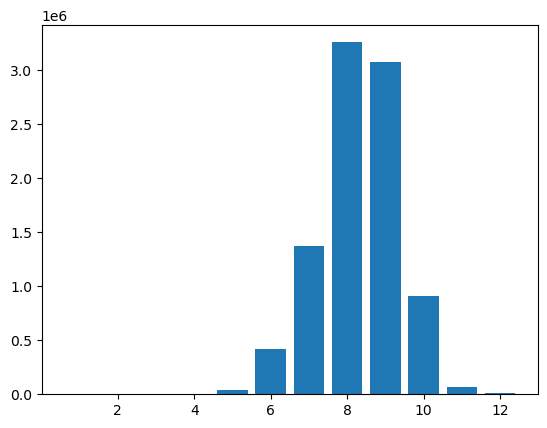

In [47]:
fig, axes = plt.subplots()
axes.bar(x = areas_month['month'], height = areas_month['area'])

And, as expected, the area aggregate does not substantially change.

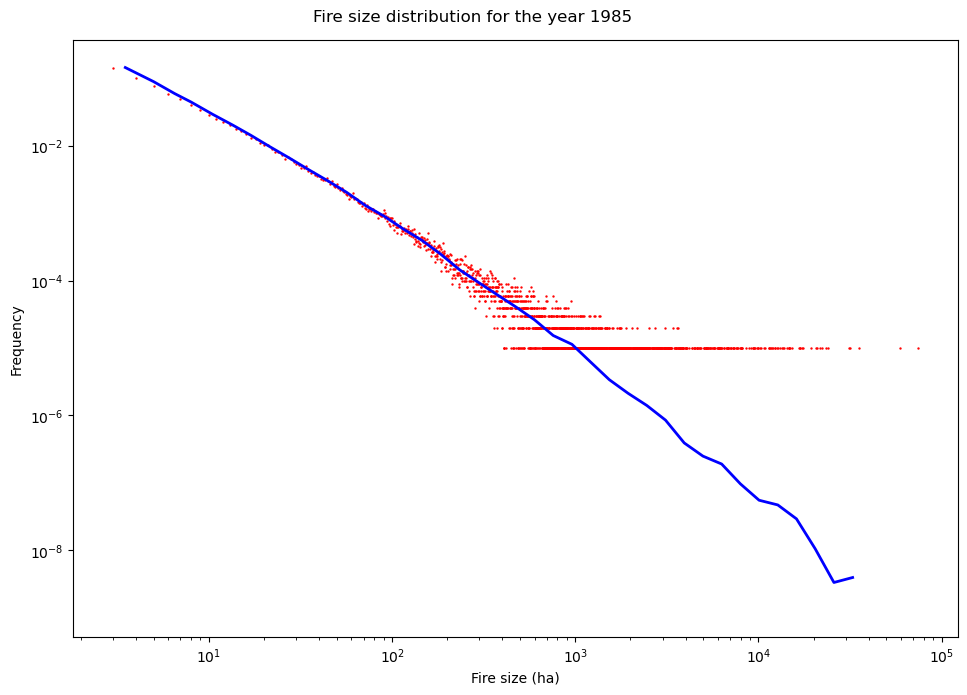

In [48]:
basic_powerLawPDF(data2[data2['area'] >= 3].sample(n=100000, replace = False)['area'], True, '1985')